#### Beam Characterization System Software for CSP Camera on Target System 
---
##### Katelyn Spadavecchia, Devon Kesseli, Mackenzie Dennis

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob 
import glob
import pandas as pd 
import os 
import cv2 
from scipy.io import loadmat 
import argparse 
import imutils
from skimage import data 
from skimage.feature import blob_dog, blob_log, blob_doh 
from math import sqrt 
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.filters import gaussian 
from skimage import img_as_ubyte
from collections import defaultdict
import sys
from skimage.transform import hough_line, hough_line_peaks
from bisect import bisect 
print("Imports complete.")
from tqdm import tqdm
import tifffile 
from skimage import img_as_float
import pywt

Imports complete.


##### Choosing image files to process
> Software only processes one image at a time. You can choose images from specific sets by uncommenting. 
* The first image set is from Crescent Dunes 
* The second image set is at OTF from images taken by Daniel Tsvankin
* The last three image sets are at OTF from Kyle Heinzman with target aspect ratios of 54, 75, 79. 

In [2]:
imageFiles = sorted(glob.glob("Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/CrescentDunes/*.bmp"),key=len)
#imageFiles = sorted(glob.glob("Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/OTF.07.21.22/otf54/*.jpg"),key=len)
#imageFiles = sorted(glob.glob("Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/OTF.07.21.22/otf75/*.jpg"),key=len)
#imageFiles = sorted(glob.glob("Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/OTF.07.21.22/otf79/*.jpg"),key=len)
#imageFiles = sorted(glob.glob("Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/OTF.07.08.22/*.jpg"),key=len)
imageFiles = sorted(glob.glob(r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023\images\*.tif"),key=len)
# imageFiles = sorted(glob.glob(r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\04_03_2021\images\Images_2\*.tif"),key=len)
for i in tqdm(range(len(imageFiles))):
  print(i, ",", imageFiles[i])
# iFile = int(input("Enter file number:"))
iFile=3
imageFile = imageFiles[iFile]
print(imageFile)

# imageFileFolder = r"Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/CrescentDunes/"




100%|██████████| 5/5 [00:00<00:00, 4995.60it/s]

0 , C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023\images\Image 2023 03 22 09h 57m 18s.tif
1 , C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023\images\Image 2023 03 22 10h 25m 23s.tif
2 , C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023\images\Image 2023 03 22 10h 28m 12s.tif
3 , C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023\images\Image 2023 03 22 12h 01m 16s.tif
4 , C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023\images\Image 2023 03 22 12h 03m 44s.tif
C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023\images\Image 2023 03 22 12h 01m 16s.tif


##### Reading in selected file, seperating color bands, displaying image, and printing image shape

(1024, 1376)


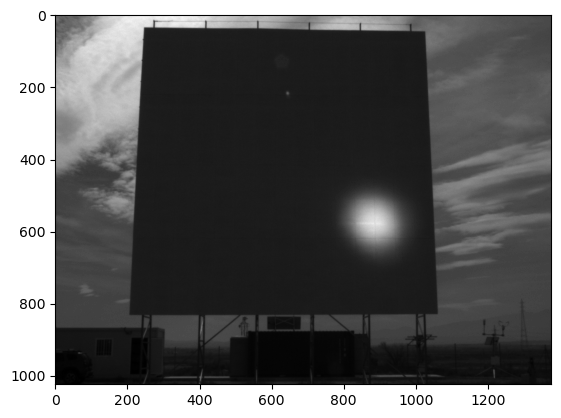

In [3]:
#reading in selected file

_, imageExtension = os.path.splitext(imageFile)
img = imread(imageFile)
if len(img.shape) == 3 and img.shape[0] > 3:
    img = img[0, :, :]
elif len(img.shape) == 3:
    img = rgb2gray(img)
else:
    img = img

# convert to 8 bit if image is 16 bit
if img.dtype == np.uint16:
    img = (img / 65535.0 * 255).astype(np.uint8)

plt.imshow(img, cmap = plt.cm.gray)

#splitting color bands
hsv = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
lower_blue = np.array([40,80,0])
upper_blue = np.array([222,222,255])
mask = cv2.inRange(hsv, lower_blue, upper_blue)
result = cv2.bitwise_and(img,img, mask=mask)
r= cv2.split(result)
g = cv2.split(result)
b = cv2.split(result)
r= cv2.split(img)
g = cv2.split(img)
b = cv2.split(img)

w = img.shape
h=img.shape
c=img.shape
img.dtype
print(w)

##### Normalizing image and improving image saturation
> The variables alpha and beta have to be adjusted with different images. 
* If the image is well saturated: alpha=1 & beta=1
* if the image is slightly dark: alpha=1 & beta=80
* if the image is still dark: alpha=2 & beta=1 
* if the image is still dark: alpha=2 & beta=80
> Because of these adjustments, I printed out successful values for alpha & beta in a csv file under Github>DataFiles. 
This is something that will need to be automated in the future. Maybe with image intensity sorting that assigns particular alpha and beta values depending on the overall image intensities. 

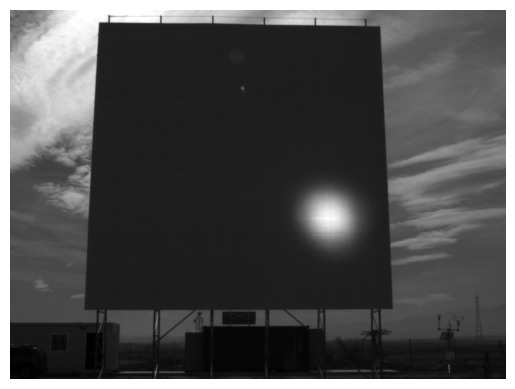

In [4]:

alpha = 2
beta = 50

im = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)

plt.imshow(im, cmap='gray')
# turn off axis
plt.axis('off')
plt.show()

##### Creating binary image by applying blur, erosion, dilation, and adaptive thresholding filters

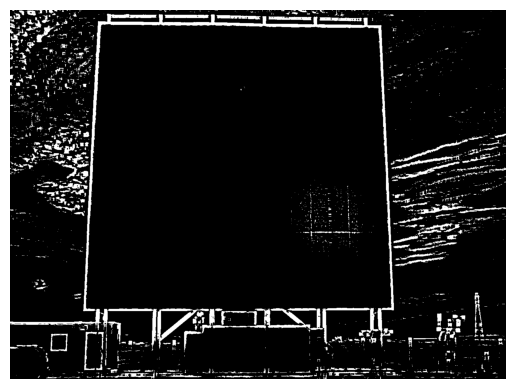

In [5]:
#Making Binary Image 
kernel = np.ones((3,3),np.uint8)
blur = cv2.blur(im, (3,3))
erodeI = 3
dilateI = 3
imerode = cv2.erode(blur,kernel,iterations = erodeI)
im_dilate = cv2.dilate(imerode,kernel,iterations = dilateI)
bin_img = cv2.adaptiveThreshold(imerode, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
bin_img = ~bin_img

plt.axis('off')


fileNum = iFile+1

plt.imshow(bin_img, cmap='gray')


##### Applying Hough Transformation. 
> The tested angles are set to look for lines that are close but not quite vertical or horizontal. This is important for intersection the Hough lines because exactly vertical lines have undefined slopes. Minimum distance is set to 150 to find unique houghpeaks in a certain space. The figure below is the hough peaks in accumulator space which is theta on the x-axis and a distance value on the y-axis. 
Since we are looking for two peaks at theta values of nearly 0, and two peaks for theta values of nearly 90, It would be helpful to search for this number of peaks in a restricted range of theta values instead of hoping the algorithm finds them correctly. In most cases, they are found correctly, but not always. 

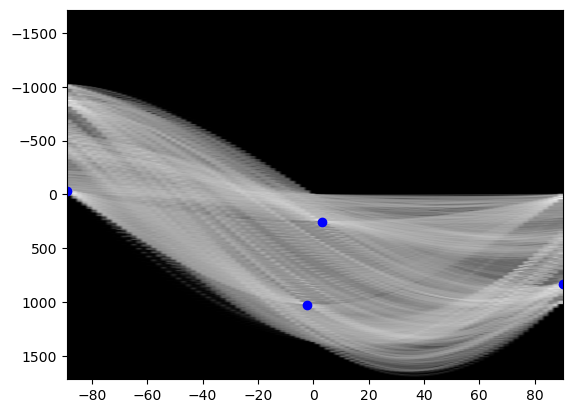

In [6]:
from skimage.transform import hough_line, hough_line_peaks

mintestangle = -89.03
maxtestangle = 90.2

tested_angles = np.linspace((mintestangle*np.pi)/180, (maxtestangle*np.pi)/180, 100) 
#tested_angles = np.linspace((-np.pi)/2, (np.pi)/2, 100)
h, theta, d = hough_line(bin_img, tested_angles)


hpeaks, angles, dists = hough_line_peaks(h,theta,d, min_distance=150, min_angle=2, threshold=150, num_peaks=4)
#print(hpeaks.shape)
#print(angles.shape)
#print(dists.shape)
#print(np.rad2deg(angles))
#print(dists)

plt.figure()
plt.imshow(np.log(h+1), aspect='auto', extent=[np.rad2deg(theta[0]), np.rad2deg(theta[-1]), d[-1], d[0]], cmap='gray')
plt.plot(np.rad2deg(angles), dists, 'bo')
#plt.axis('off')

plt.show()

##### Extracting HoughLines and finding their intersection points 
> Setting $x$ and $y$ equal to get the intersection points of 2 lines. 

$$m_1x + b_1 = m_2x + b_2$$

$$x_{int} = \frac{b_2-b_1}{m_1-m_2}$$

$$y_{int} = m_1 x_{int} +b_1 $$

> The Hough Transormation orders lines based on the most amount of votes, so the order of the lines can change without being noticed. This means that some sorting had to be done in order to make sure that we were actually intersecting lines that had an intersection point (and not parallel lines). I did the sorting by finding all of the possiple intersections. There are 6 possible intersection points with 2 of them not being good, and these are very large positive numbers (since the intersection points occur are very large either positive or negative pixel values). With this knowledge, we sorted them based on their value and discarded the first two intersections. 

> Since the origin (0,0) is the top left corner, the largest pixel value will be the bottom right. The smallest pixel value is the top left. 

Top Left Corner:  (250.32856865521057, 36.242977318873955)
Top Right Corner:  (1029.5496672049965, 49.43621235816022)
Lower Right Corner:  (1058.7268486478365, 833.700725562685)
Lower Left Corner:  (204.51094130637188, 830.7189374307468)
Center of the Target:  (654.5277086515235, 434.97185144077946)


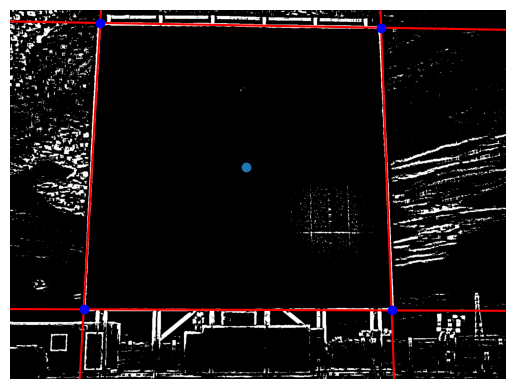

In [7]:
# TODO: problem exist here that corners are not correctly found

from pyparsing.util import lineno
plt.figure()
plt.imshow(bin_img, cmap=plt.cm.gray)

lines = np.zeros((4,4)) #save all points
slopes = np.zeros((4,1)) #calc slopes
y_ints = np.zeros((4,1)) #calc y-intercepts

for i in range(len(hpeaks)):
  x0 = 1
  x1 = bin_img.shape[1] 
  y0 = (dists[i]-x0*np.cos(angles[i]))/np.sin(angles[i]) 
  y1 = (dists[i]-x1*np.cos(angles[i]))/np.sin(angles[i])
  lines[i,:] = [x0, x1, y0, y1] #save points
  slopes[i] = (y1-y0)/(x1-x0) #save slope
  y_ints[i] = -slopes[i]*x0+y0 #save y-intercept
  line = (x0,x1),(y0,y1)
  #print(line)
  plt.plot((x0,x1),(y0,y1), '-r')


plt.xlim((0,bin_img.shape[1]))
plt.ylim((bin_img.shape[0],0))

def intersector(slp1, int1, slp2, int2):
  #print("Slope A: ", slp1, "Slope B :", slp2 )
 
  x_int = abs((int2-int1))/abs((slp1-slp2))
  y_int = slp1*x_int+int1
  return (x_int[0], y_int[0])

#All possible intersections (Some will not yield any intersections)

int_1 = intersector(slopes[0], y_ints[0], slopes[1], y_ints[1])
int_2 = intersector(slopes[0], y_ints[0], slopes[2], y_ints[2])
int_3 = intersector(slopes[0], y_ints[0], slopes[3], y_ints[3])
int_4 = intersector(slopes[1], y_ints[1], slopes[2], y_ints[2])
int_5 = intersector(slopes[1], y_ints[1], slopes[3], y_ints[3])
int_6 = intersector(slopes[2], y_ints[2], slopes[3], y_ints[3])

# valid intersections should be those inside of the image
def valid_intersections(ints_list, img_shape):
  """
  find valid intersections and organize them in a list
  """
  valid_ints = []
  for i in ints_list:
    if i[0] > 0 and i[0] < img_shape[1] and i[1] > 0 and i[1] < img_shape[0]:
      valid_ints.append(i)

  def organize_positions(positions):
    # Sort by y-coordinate (top to bottom)
    positions_sorted = sorted(positions, key=lambda pos: pos[1])
    
    # Split into top and bottom halves
    top_positions = positions_sorted[:2]
    bottom_positions = positions_sorted[2:]
    
    # Sort top positions by x-coordinate (left to right)
    top_left = min(top_positions, key=lambda pos: pos[0])
    top_right = max(top_positions, key=lambda pos: pos[0])
    
    # Sort bottom positions by x-coordinate (left to right)
    bottom_left = min(bottom_positions, key=lambda pos: pos[0])
    bottom_right = max(bottom_positions, key=lambda pos: pos[0])
    
    return [top_left, top_right, bottom_left, bottom_right]
  
  return organize_positions(valid_ints)
  

#sort intersections
#There's always going to be two that don't work, these two are always going to be the first two since they are large positive numbers
def get_max(sub):
  return max(sub)

test_list = [int_1, int_2, int_3, int_4, int_5, int_6]
# test_list.sort(key = get_max, reverse = True)
#print("Sorted Tuples: " + str(test_list))

sorted_ints = valid_intersections(test_list, bin_img.shape)
int_TL = sorted_ints[0]
int_TR = sorted_ints[1]
int_LR = sorted_ints[3]
int_LL = sorted_ints[2]
# int_TL =  test_list[5]
# int_TR =  test_list[3]
# int_LL = test_list[4]
# int_LR = test_list[2]

print("Top Left Corner: ", int_TL)
print("Top Right Corner: ", int_TR)
print("Lower Right Corner: ",int_LR)
print("Lower Left Corner: ",int_LL)

corners = [(int_TL),(int_TR), (int_LR), (int_LL)]
x_val = [x[0] for x in corners]
y_val = [x[1] for x in corners]
plt.plot(x_val,y_val, 'bo')

#finding the center of the target given the coordinates of the edges 
x_midpt = 0.5*(int_TL[0]+int_LR[0])
y_midpt = 0.5*(int_TL[1] + int_LR[1])
plt.plot(x_midpt,y_midpt, "o")
target_mid = (x_midpt, y_midpt)
print("Center of the Target: ",target_mid)


#finding pixels across target
Px = 0.5*(abs(int_TL[0] - int_TR[0]) + abs(int_LL[0] - int_LR[0]))
Py = 0.5*(abs(int_TL[1] - int_LL[1]) + abs(int_TR[1] - int_LR[1]))


plt.axis('off')
#plt.title("Detected Lines")
#plt.savefig('/content/drive/MyDrive/NREL/ProcessedIms/DetectedEdges/CrescentDunes/' + "Image" + str(fileNum) + 'Detected', dpi = 300, bbox_inches='tight', pad_inches=0)
plt.show()

##### Saving the corner locations in a CSV File under Github>DataFiles

In [8]:
import csv 
f = open('Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/DataFiles/CrescentDunes/TargetEdges/TargetEdges' + "File" + str(fileNum), 'w')
theWriter = csv.writer(f)
theWriter.writerow(['Image','Alpa', 'Beta','Erosions','Dilations','Top Left Corner','Top Right Corner','Lower Left Corner','Lower Right Corner'])
theWriter.writerow([fileNum,alpha,beta,erodeI,dilateI,int_TL,int_TR,int_LL,int_LR])

180

#### Beam Characterization 
---
##### Now that the Target corners have been detected, we can crop the image so that we are only focused on the target locations and we resize the image to the original image size, which in the case of the images at Crescent Dunes was 1936x1456. 

> What I'm realizing now might be better is instead of cropping the image would be to make a mask of the image so that we are focused on just the target area without changing the shape of the beam on the overall image.
> I've cropped the image without resizing and modified the bounds to be a "mean" rectangle based on corner locations, rather than using a mix of x- and y-values from three corners. There may be some additional work to re-aspect the image to a proper rectangle, given that the four points will always make a trapezoid or parallelagram due to the camera-target angle. DAT 04-19-24

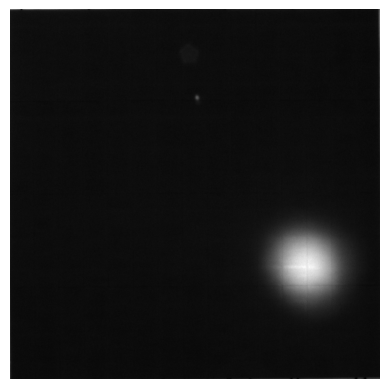

In [9]:
# perspective transform of the image accroding to the four corners
# target positions are [0, 0], [0, 1000], [1000, 0], [1000, 1000]
dst_img_size = 1000

src_points = np.float32([
    int_TL,  # Top-left
    int_TR,  # Top-right
    int_LL,  # Bottom-left
    int_LR  # Bottom-right
])

# Define the destination points (corners of the transformed image)
dst_points = np.float32([
    [0, 0],  # Top-left
    [dst_img_size, 0],  # Top-right
    [0, dst_img_size],  # Bottom-left
    [dst_img_size, dst_img_size]  # Bottom-right
])

perspectiveTransformMatrix = cv2.getPerspectiveTransform(src_points, dst_points)
transfromed_img = cv2.warpPerspective(img, perspectiveTransformMatrix, (dst_img_size, dst_img_size))
croppedIm = transfromed_img[0:dst_img_size, 0:dst_img_size]


plt.axis("off")
plt.imshow(croppedIm, cmap = plt.cm.gray)

> Wavelet or FFT can be used to filter out the background irrevalant noises for beam characterization

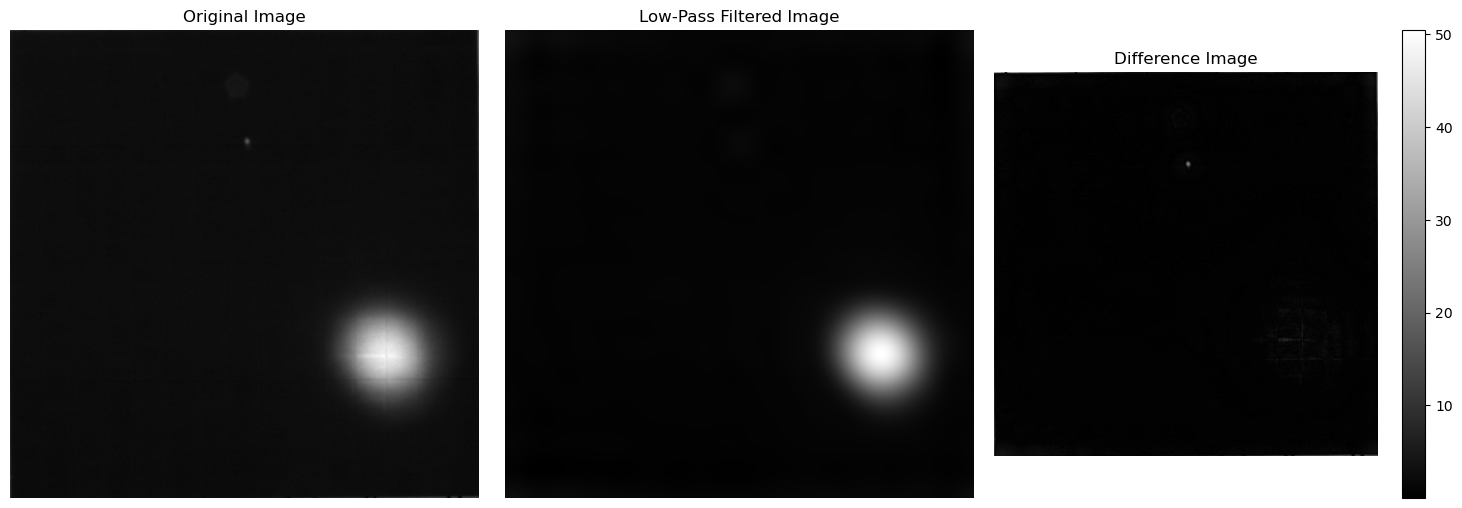

In [10]:
def low_pass_filter(image, keep_ratio):
    # Convert the image to grayscale if it is not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Get the dimensions of the image
    rows, cols = image.shape
    
    # Perform the 2D FFT
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    
    # Create a mask with the same dimensions as the image
    mask = np.zeros((rows, cols), np.uint8)
    
    # Calculate the center of the image
    crow, ccol = rows // 2 , cols // 2
    
    # Determine the size of the low-pass filter
    keep_rows = int(rows * keep_ratio / 2)
    keep_cols = int(cols * keep_ratio / 2)
    
    # Apply the mask to keep the low frequency components
    mask[crow-keep_rows:crow+keep_rows, ccol-keep_cols:ccol+keep_cols] = 1
    
    # Apply the mask to the shifted FFT
    fshift = fshift * mask
    
    # Perform the inverse FFT
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    
    return img_back

low_pass_fft_img = low_pass_filter(croppedIm, 0.02)

img_differences = np.abs(croppedIm - low_pass_fft_img)

# side by side comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(croppedIm, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(low_pass_fft_img, cmap='gray')
plt.title('Low-Pass Filtered Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(img_differences, cmap='gray')
plt.title('Difference Image')
plt.axis('off')
# colorbar
plt.colorbar()
plt.tight_layout()

plt.show()



In [11]:
# find the center of the brightest spot
def find_centroid(img):
    img = img_as_float(img)
    M = np.sum(img)
    y_indices, x_indices = np.indices(img.shape)
    X_c = np.sum(x_indices * img) / M
    Y_c = np.sum(y_indices * img) / M
    return X_c, Y_c

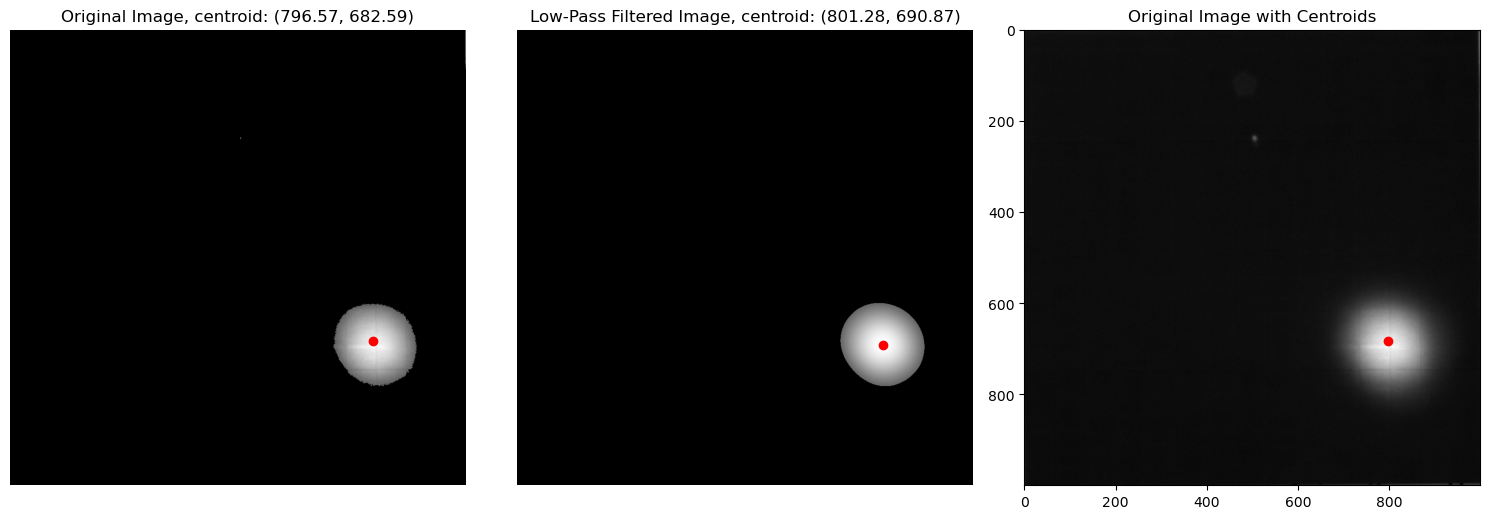

In [12]:
# ostu thresholding
croppedIm = croppedIm.astype(np.uint8).copy()
low_pass_fft_img = low_pass_fft_img.astype(np.uint8).copy()

croppedIm_otsu = cv2.threshold(croppedIm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
low_pass_im_otsu = cv2.threshold(low_pass_fft_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# mask the cropped image
masked_croppedIm = cv2.bitwise_and(croppedIm, croppedIm, mask=croppedIm_otsu)
masked_lowpassIm = cv2.bitwise_and(low_pass_fft_img, low_pass_fft_img, mask=low_pass_im_otsu)

centroid_x_unmodified, centroid_y_unmodified = find_centroid(masked_croppedIm.copy())
centroid_x_low_pass, centroid_y_low_pass = find_centroid(masked_lowpassIm.copy())

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(masked_croppedIm, cmap='gray')
plt.plot(centroid_x_unmodified, centroid_y_unmodified, 'ro')
plt.title(f'Original Image, centroid: ({centroid_x_unmodified:.2f}, {centroid_y_unmodified:.2f})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masked_lowpassIm, cmap='gray')
plt.plot(centroid_x_low_pass, centroid_y_low_pass, 'ro')
plt.title(f'Low-Pass Filtered Image, centroid: ({centroid_x_low_pass:.2f}, {centroid_y_low_pass:.2f})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(croppedIm, cmap='gray')
plt.plot(centroid_x_unmodified, centroid_y_unmodified, 'ro')

plt.title('Original Image with Centroids')

plt.tight_layout()
plt.show()



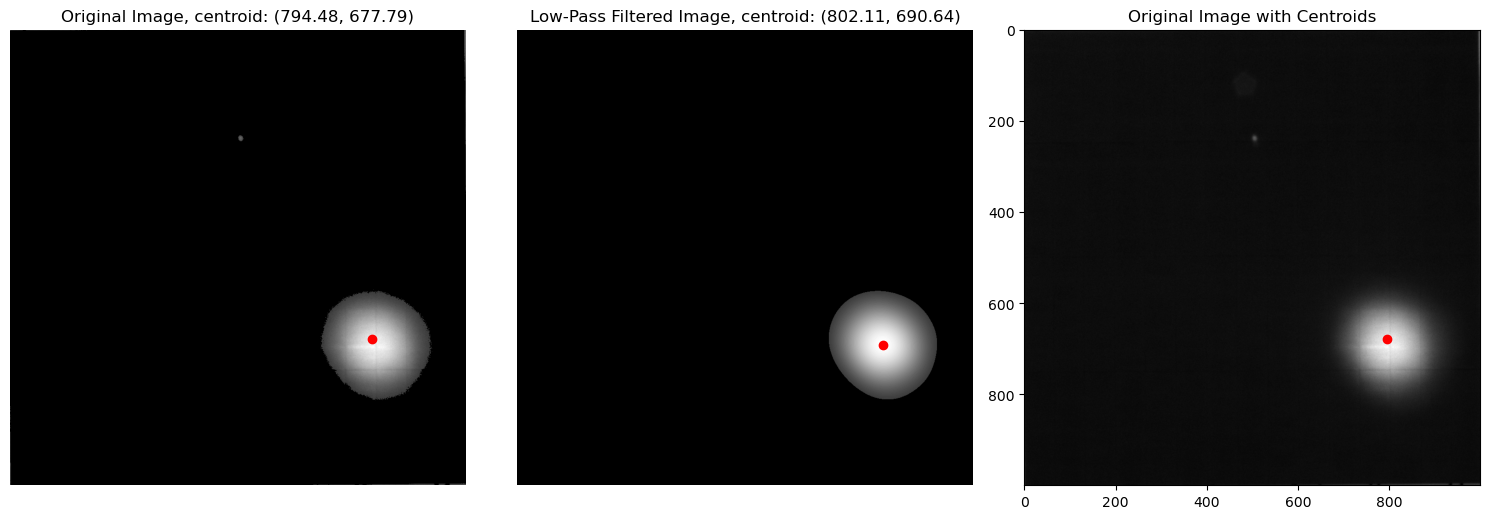

In [13]:
# another method, using histgram to find the most frequent value, and add 2 to get the threshold
croppedIm = croppedIm.astype(np.uint8)
low_pass_fft_img = low_pass_fft_img.astype(np.uint8)
hist_croppedIm, bins_croppedIm = np.histogram(croppedIm.copy().flatten(), 256, [0, 256]) 
hist_croppedIm_freq_bin = np.argmax(hist_croppedIm)
croppedIm_threshold_val = hist_croppedIm_freq_bin + 10

hist_lowpassIm, bins_lowpassIm = np.histogram(low_pass_fft_img.copy().flatten(), 256, [0, 256])    
hist_lowpassIm_freq_bin = np.argmax(hist_lowpassIm)
lowpassIm_threshold_val = hist_lowpassIm_freq_bin + 10

# thresholding
_, croppedIm_thresh = cv2.threshold(croppedIm.copy(), croppedIm_threshold_val, 255, cv2.THRESH_BINARY)
_, lowpassIm_thresh = cv2.threshold(low_pass_fft_img.copy(), lowpassIm_threshold_val, 255, cv2.THRESH_BINARY)

# mask the cropped image
masked_croppedIm_thresh = cv2.bitwise_and(croppedIm.copy(), croppedIm, mask=croppedIm_thresh)
masked_lowpassIm_thresh = cv2.bitwise_and(low_pass_fft_img.copy(), low_pass_fft_img, mask=lowpassIm_thresh)

centroid_x_thresh, centroid_y_thresh = find_centroid(masked_croppedIm_thresh)
centroid_x_low_pass_thresh, centroid_y_low_pass_thresh = find_centroid(masked_lowpassIm_thresh)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(masked_croppedIm_thresh, cmap='gray')
plt.plot(centroid_x_thresh, centroid_y_thresh, 'ro')
plt.title(f'Original Image, centroid: ({centroid_x_thresh:.2f}, {centroid_y_thresh:.2f})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(masked_lowpassIm_thresh, cmap='gray')
plt.plot(centroid_x_low_pass_thresh, centroid_y_low_pass_thresh, 'ro')
plt.title(f'Low-Pass Filtered Image, centroid: ({centroid_x_low_pass_thresh:.2f}, {centroid_y_low_pass_thresh:.2f})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(croppedIm, cmap='gray')
plt.plot(centroid_x_thresh, centroid_y_thresh, 'ro')
plt.title('Original Image with Centroids')

plt.tight_layout()
plt.show()


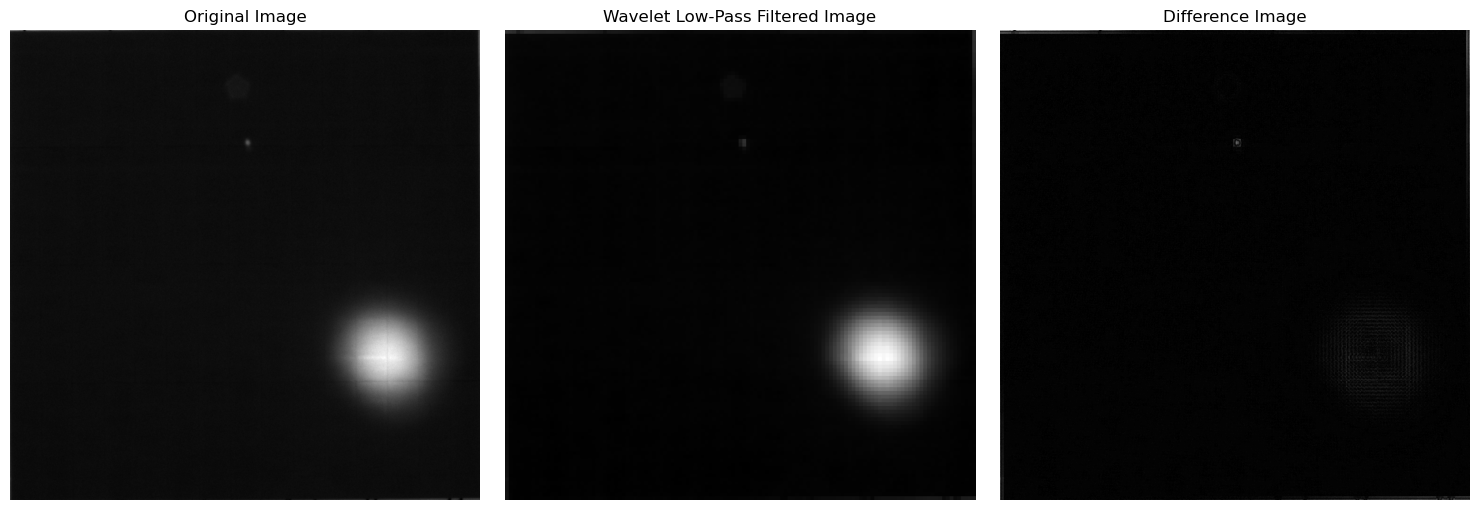

In [14]:
# Perform wavelet low pass
wavelet  = 'db1'
croppedIm = img_as_float(croppedIm)
coeffs = pywt.wavedec2(croppedIm, wavelet, level=3)
low_freq_coeffs = [coeffs[0]] + [(np.zeros_like(cH), np.zeros_like(cV), np.zeros_like(cD)) for cH, cV, cD in coeffs[1:]]
low_freq_image = pywt.waverec2(low_freq_coeffs, wavelet)

img_difference = np.abs(croppedIm - low_freq_image)

# side by side comparison
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(croppedIm, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(low_freq_image, cmap='gray')
plt.title('Wavelet Low-Pass Filtered Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_difference, cmap='gray')
plt.title('Difference Image')
plt.axis('off')
plt.tight_layout()

plt.show()

##### Blurring, erosion, dilation canny, and adaptive thresholding filters were applied to accentuate the shape of the beam on the target

In [15]:
 
kernel = np.ones((3,3),np.uint8)
blur = cv2.blur(croppedIm, (3,3))
erodeI = 5
dilateI = 15
imerode = cv2.erode(blur,kernel,iterations = erodeI)
im_dilate = cv2.dilate(imerode,kernel,iterations = dilateI)

imedge = cv2.Canny(im_dilate, 8,19)
img_th = cv2.adaptiveThreshold(imedge, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
#img_th=~img_th  
#finding contours is easier when the contours themselves are in white. The contour I am looking for is the innermost contour that is in white. 

plt.axis('off')

#morphlogy to remove unwanted noise
img_th = cv2.morphologyEx(img_th, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)))
plt.imshow(img_th, cmap='gray')


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\canny.cpp:829: error: (-215:Assertion failed) _src.depth() == CV_8U in function 'cv::Canny'


##### Finding contours
> RETR_CCOMP is a good method for finding both exterior and interior contours and distinguishing them. 

>CHAIN_APPROX_SIMPLE is good for finding less duplicate and more unique contours 

In [ ]:

contours, heirarchy = cv2.findContours(img_th, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
#img_th=~img_th
src_copy =img_th.copy()
src_copy = cv2.cvtColor(src_copy, cv2.COLOR_BGR2RGB)

for i, cont in enumerate(contours):
  if heirarchy[0][i][3] == -1:
    src_copy = cv2.drawContours(src_copy, cont, -1, (0,255,0), 5)
  else:
    src_copy = cv2.drawContours(src_copy, cont, -1, (0,0,255),5)

print("Numer of Contours: {}".format(len(contours)))
#sorted_contours = sorted(contour1, key=cv2.contourArea, reverse= True)
#for i, cont in enumerate(sorted_contours[:3],1):
 # cv2.drawContours(img, contour1, -1, (0,255,0), 3)
  #cv2.putText(im, str(i), (cont[0,0,1]-10), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (0,255,0), 4)


plt.figure(figsize=[5,5])
plt.imshow(src_copy);plt.title("Beam Contour");plt.axis('off')





##### filtering the contours, and fitting elipses to them
> The $x$ and $y$ components of the ellispe centroid are found along with the ellipse eccentricity and are saved in a csv file under Github>DataFiles.

In [ ]:
#R = distance heliostat to target in meters
# W = width of the target in meters
# H = height of the target in meters
R = 120
W = 2.0 
H = 2.2


from numpy.ma.core import arctan
def eccentricity_from_ellipse(contour):
    """Calculates the eccentricity fitting an ellipse from a contour"""

    (x, y), (MA, ma), angle = cv2.fitEllipse(contour)

    a = ma / 2
    b = MA / 2

    ecc = np.sqrt(a ** 2 - b ** 2) / a
    return ecc 



cnts, hiers = cv2.findContours(img_th, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)[-2:]
src_copy =img_th.copy()
src_copy = cv2.cvtColor(src_copy, cv2.COLOR_BGR2RGB)

max_area = 500000
min_area = 10000


for i, cont in enumerate(cnts):
  if heirarchy[0][i][3] == -1:
    src_copy = cv2.drawContours(src_copy, cont, -1, (0,255,0), 5)
  else:
    src_copy = cv2.drawContours(src_copy, cont, -1, (0,0,255),5)
  
  
for ic,cnt in enumerate(cnts): 
  area = cv2.contourArea(cnt)
  if min_area <= area <= max_area:
    ellipse = cv2.fitEllipse(cnt)
    cv2.ellipse(src_copy, ellipse, (255,0,0), 10, cv2.LINE_AA)
    M = cv2.moments(cnt)
    cX = int(M["m10"]/M["m00"])
    cY = int(M["m01"]/M["m00"])
    cv2.circle(src_copy, (cX,cY), 7, (255,0,0), -1)
    print("Centroid: ",(cX,cY))
    eccentricity = eccentricity_from_ellipse(cnt)
    print("Eccentricity: ",eccentricity)
    f1 = open('Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/DataFiles/CrescentDunes/BeamContour/BeamContour' + "File" + str(fileNum), 'w')
    theWriter1 = csv.writer(f1)
    theWriter1.writerow(['Centroids','Eccentricity'])
    theWriter1.writerow([(cX,cY), eccentricity])
    
    Centroid = (cX,cY)
    print("Centroid: ",(cX,cY))

    #finding ∆r 
    dx = abs(Centroid[0]-target_mid[0])
    dy = abs(Centroid[1]-target_mid[1])
    dr = sqrt((dx)**2 +(dy)**2)
    print("∆x: ",dx)
    print("∆y: ", dy)
    print("∆r" , dr)

    #finding the pixel extent
    PEx = W/Px
    PEy = H/Py
    print("Pixel Extent: ", (PEx,PEy))

    #finding Phi altitude 
    phi_alt = arctan(((dy*PEy)/R))
    print("Altitude tracking error in meters: ",phi_alt) # in meters


    #finding Phi elevation 
    phi_elv = arctan(((dx*PEx)/R))
    print("Tracking error in Elevation: ", phi_elv) # in meters

   

  
plt.figure(figsize=[5,5])
plt.axis('off')
plt.imshow(src_copy)

plt.savefig('Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/DataFiles/CrescentDunes/ProcessedIms/BeamDetection/' + "Image" + str(fileNum), bbox_inches='tight', pad_inches=0)
 

